# Loading data / preprocessing

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as p
import os


# RUN_PATH = "/mnt/ssd/SSD_floricslimani/Fish_seq/Davide/2024-10-09 - SeqFISH_Run10 - HeLa-Puro_POLR2" 
RUN_PATH = "/mnt/ssd/SSD_floricslimani/Fish_seq/Davide/2024-10-02 - SeqFISH_Run9 - HeLa _POLR2"

OUTPUT_PATH = RUN_PATH + "/analysis/density/"
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [21]:
Acquisition = pd.read_feather(RUN_PATH + "/result_tables/Acquisition.feather")
Detection = pd.read_feather(RUN_PATH + "/result_tables/Detection.feather", columns= ['voxel_size'])
Drift = pd.read_feather(RUN_PATH + "/result_tables/Drift.feather")

VOXEL_SIZE = tuple(Detection['voxel_size'].iat[0])
VOXEL_SIZE = [int(i) for i in VOXEL_SIZE]


In [22]:
check_len = len(Drift)
if 'cycle' not in Drift.columns :
    Drift = pd.merge(
        Drift,
        Acquisition.loc[:,['acquisition_id', 'cycle']],
        on= 'acquisition_id'
    )
assert len(Drift) == check_len
Drift

,drift_id,acquisition_id,drift_type,drift_z,drift_y,drift_x,voxel_size,bead_size,removed_slices,highpass_filter,max_projection,error,phasediff,location,cycle
0,0,0,fish,0,0,0,"[200, 97, 97]","[200, 200, 200]",None,False,None,NaN,NaN,Location-01,0
1,1,0,dapi,-20,-2,0,"[200, 97, 97]","[200, 200, 200]",None,False,None,1.0,-1.303506e-17,Location-01,0
2,2,10,fish,0,2,-2,"[200, 97, 97]","[200, 200, 200]",None,False,False,1.0,-2.509373e-17,Location-01,1
3,3,20,fish,0,3,0,"[200, 97, 97]","[200, 200, 200]",None,False,False,1.0,-1.176728e-17,Location-01,2
4,4,30,fish,0,5,-2,"[200, 97, 97]","[200, 200, 200]",None,False,False,1.0,-1.031082e-17,Location-01,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,225,179,fish,0,8,1,"[200, 97, 97]","[200, 200, 200]",None,False,False,1.0,4.052054e-17,Location-10,17
226,226,189,fish,0,8,2,"[200, 97, 97]","[200, 200, 200]",None,False,False,1.0,1.998815e-17,Location-10,18
227,227,199,fish,0,8,2,"[200, 97, 97]","[200, 200, 200]",None,False,False,1.0,3.092282e-17,Location-10,19
228,228,209,fish,0,8,3,"[200, 97, 97]","[200, 200, 200]",None,False,False,1.0,1.855270e-17,Location-10,20


# Statistics

## Correction sucess rate

### General

In [23]:
dapi_mask = (~Drift['error'].isna()) & (Drift['drift_type'] == 'dapi')
fish_mask = (~Drift['error'].isna()) & (Drift['drift_type'] == 'fish')

In [24]:
dapi_sucess = Drift.loc[dapi_mask & ((Drift["drift_z"] != 0) | (Drift["drift_y"] != 0) | (Drift["drift_x"] != 0))]

dapi_sucess_number = len(dapi_sucess)
dapi_test_number = len(Drift[dapi_mask])
dapi_fail_number = dapi_test_number - dapi_sucess_number

dapi_sucess_percentage = dapi_sucess_number*100/dapi_test_number
dapi_fail_percentage = dapi_fail_number*100/dapi_test_number

In [25]:
fish_sucess = Drift.loc[fish_mask & ((Drift["drift_z"] != 0) | (Drift["drift_y"] != 0) | (Drift["drift_x"] != 0))]

fish_sucess_number = len(fish_sucess)
fish_test_number = len(Drift[fish_mask])
fish_fail_number = fish_test_number - fish_sucess_number

fish_sucess_percentage = fish_sucess_number*100/fish_test_number
fish_fail_percentage = fish_fail_number*100/fish_test_number

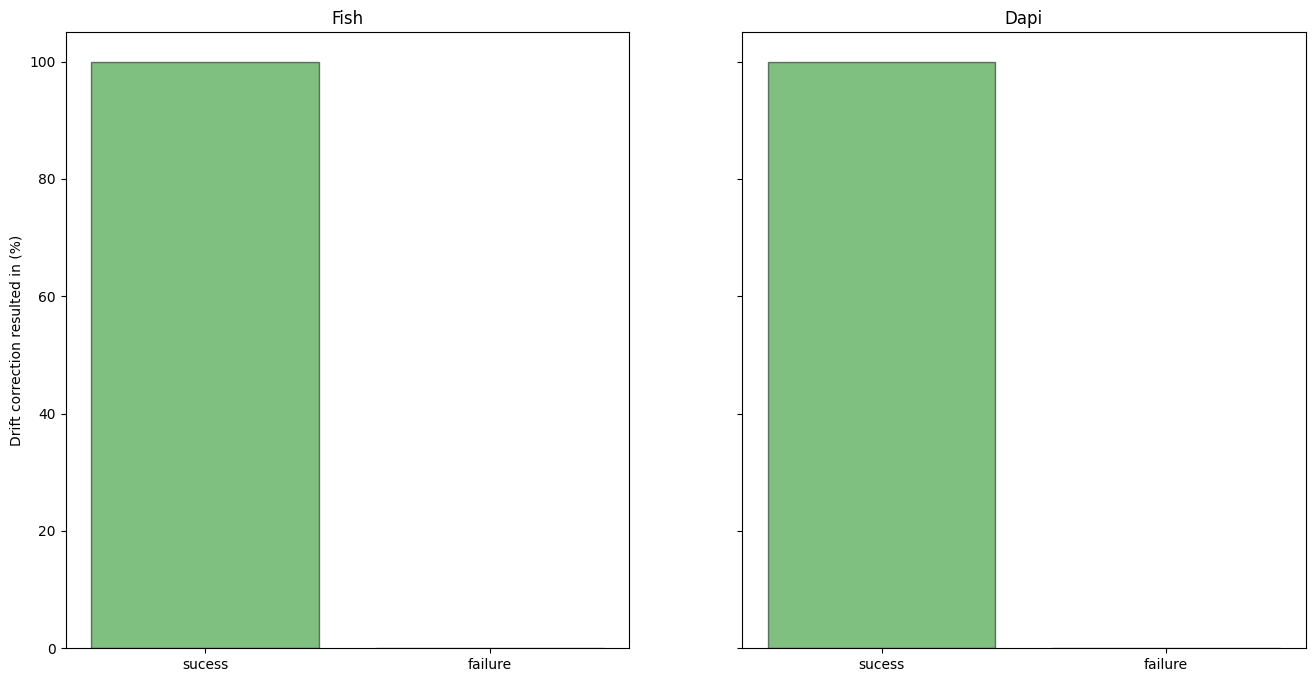

In [39]:
fig, axes = plt.subplots(1,2, figsize=(16,8), sharey=True)
axes : 'list[plt.Axes]'
fish, dapi = axes

fish.bar(['sucess', 'failure'], [fish_sucess_percentage, fish_fail_percentage], color=['green', 'red'], alpha = 0.5, edgecolor= 'black')
dapi.bar(['sucess', 'failure'], [dapi_sucess_percentage, dapi_fail_percentage], color=['green', 'red'], alpha = 0.5, edgecolor= 'black')

fish.set_title('Fish')
dapi.set_title('Dapi')
fish.set_ylabel("Drift correction resulted in (%)")

plt.show()

### Per cycle

In [27]:
Drift['sucess'] = (Drift['drift_z'] != 0) | (Drift['drift_y'] != 0) | (Drift['drift_x'] | 0)
per_cycle_sucess = Drift.loc[~Drift['error'].isna()].groupby(['drift_type','cycle']).agg({
    'sucess' : ['sum','count'],
})

per_cycle_sucess.columns = ['sucess', 'total']
per_cycle_sucess['sucess_percentage'] = per_cycle_sucess['sucess']*100/per_cycle_sucess['total']
per_cycle_sucess

sucess  total  sucess_percentage
drift_type cycle                                  
dapi       0          10     10              100.0
fish       1          10     10              100.0
           2          10     10              100.0
           3          10     10              100.0
           4          10     10              100.0
           5          10     10              100.0
           6          10     10              100.0
           7          10     10              100.0
           8          10     10              100.0
           9          10     10              100.0
           10         10     10              100.0
           11         10     10              100.0
           12         10     10              100.0
           13         10     10              100.0
           14         10     10              100.0
           15         10     10              100.0
           16         10     10              100.0
           17         10     10              100.0
           18         10     10              100.0
           19         10     10              100.0
           20         10     10              100.0
           21         10     10              100.0

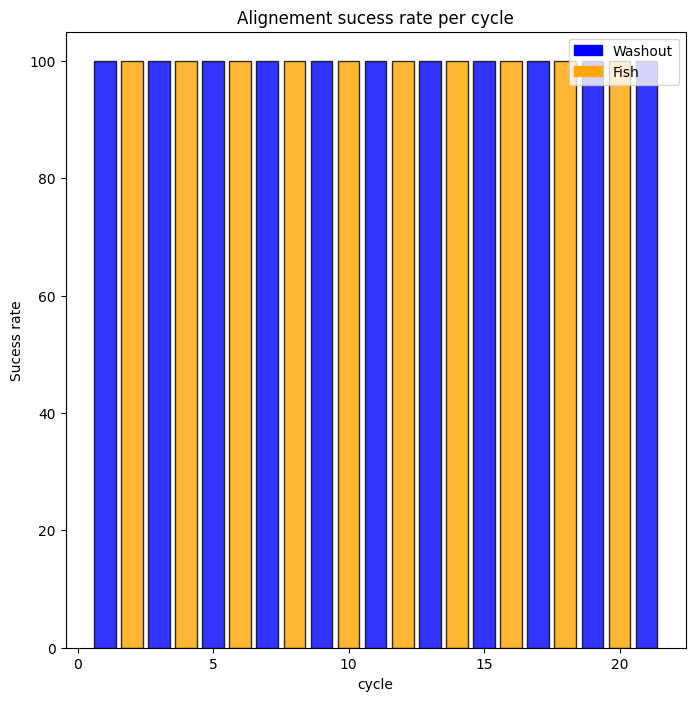

In [43]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()

X = per_cycle_sucess.loc['fish'].index
Y = per_cycle_sucess.loc['fish']['sucess_percentage']
color = ['blue','orange']
labels = ['fish', 'washout']

legend_symb = [p.Rectangle((0,0),0,1, color= 'blue'), p.Rectangle((0,0),0,1, color= 'orange')]
plt.legend(legend_symb,['Washout','Fish'])

ax.bar(X, Y, color=color, alpha = 0.8, edgecolor='black')
ax.set_ylabel('Sucess rate')
ax.set_xlabel('cycle')
ax.set_title('Alignement sucess rate per cycle')

plt.show()

## Drift distance

In [29]:
def compute_euclidian_drift(df: pd.DataFrame, voxel_size) :
    df.loc[:,['drift_z', 'drift_y', 'drift_x']] *= voxel_size
    df_sq = df.apply(np.square).sum(axis=1)
    df['euclidian_drift'] = df_sq.apply(np.sqrt)
    return df

In [30]:
fish_drift = Drift[(~Drift['error'].isna()) & (Drift['drift_type'] == 'fish')].loc[:,['cycle','drift_z', 'drift_y', 'drift_x']]
fish_drift = compute_euclidian_drift(fish_drift, VOXEL_SIZE)
fish_drift


,cycle,drift_z,drift_y,drift_x,euclidian_drift
2,1,0,194,-194,274.359254
3,2,0,291,0,291.006873
4,3,0,485,-194,522.369601
5,4,0,485,0,485.016495
6,5,0,485,-97,494.630165
...,...,...,...,...,...
225,17,0,776,97,782.223753
226,18,0,776,194,800.084995
227,19,0,776,194,800.108118
228,20,0,776,291,829.009650


In [31]:
dapi_drift = Drift.loc[(~Drift['error'].isna()) & (Drift['drift_type'] == 'dapi')].loc[:,['cycle','drift_z', 'drift_y', 'drift_x']]
dapi_drift = compute_euclidian_drift(dapi_drift, VOXEL_SIZE)
dapi_drift

,cycle,drift_z,drift_y,drift_x,euclidian_drift
1,0,-4000,-194,0,4004.701737
24,0,-1000,-97,0,1004.693486
47,0,-800,-97,97,811.676044
70,0,-2000,-97,0,2002.350868
93,0,-1000,-97,-97,1009.365147
116,0,-1400,-97,0,1403.356334
139,0,1000,-194,0,1018.644197
162,0,-1000,-97,0,1004.693486
185,0,-1000,-97,97,1009.365147
208,0,1400,-97,97,1406.704660


### Absolute drift distance

In [32]:
Z_score = 1.645 #90% confidence interval
T_score = 1.833 #90% confidence interval; n = 10

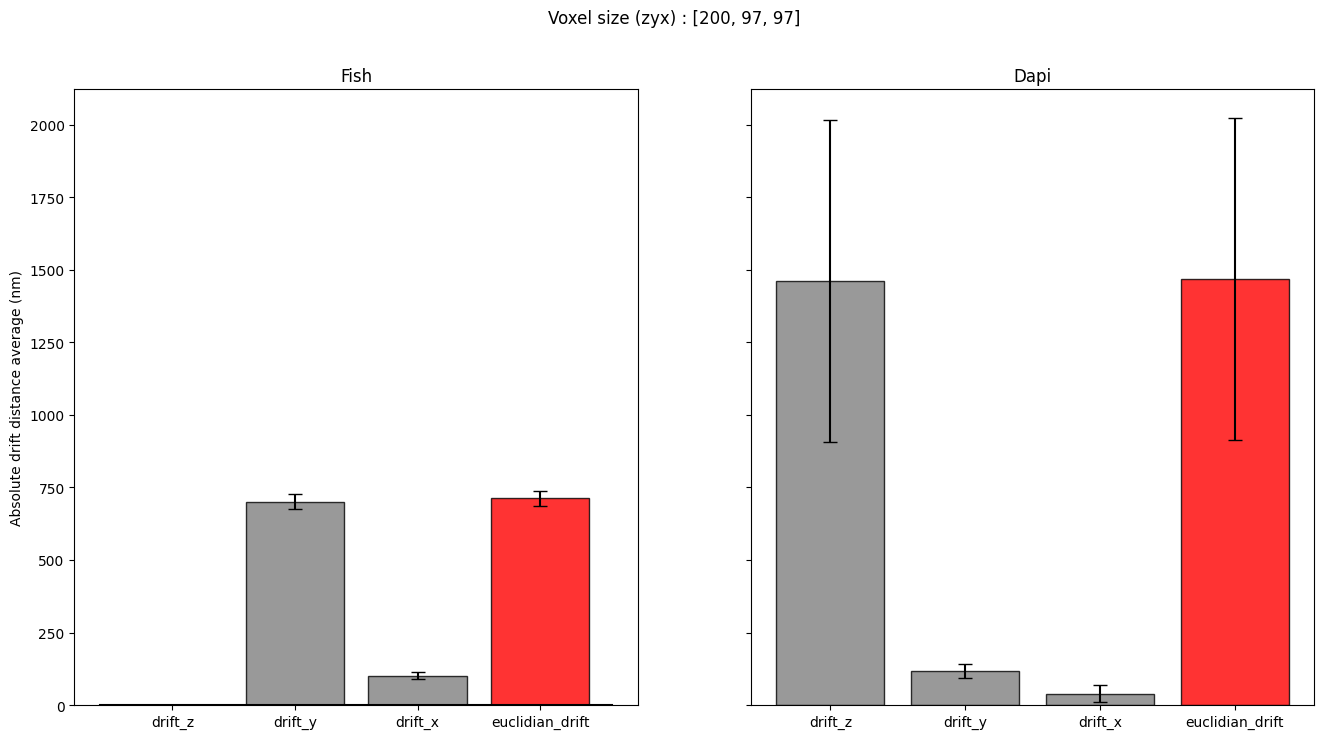

In [49]:
fig, axes = plt.subplots(1,2, figsize=(16,8), sharey=True)
fish, dapi = axes

fish_data = fish_drift.drop(columns='cycle')
dapi_data = dapi_drift.drop(columns='cycle')

fish_mean = fish_data.apply(np.abs).mean(axis=0)

fish_std = fish_data.apply(np.abs).std(axis=0)
fish_count = fish_data.count(axis=0)
confidence_interval = (T_score*fish_std) / fish_count.apply(np.sqrt)

colors = ['gray', 'gray', 'gray', 'red']

fish.bar(
    fish_mean.index, 
    fish_mean, 
    yerr=confidence_interval, 
    capsize=5,
    color=colors,
    alpha=0.8,
    edgecolor='black'
    )

xmin,xmax,ymin,ymax = fish.axis()
fish.plot([xmin,xmax], [0,0],'k')
fish.set_title('Fish')
fish.set_ylabel('Absolute drift distance average (nm)')

dapi_mean = dapi_data.apply(np.abs).mean(axis=0)
dapi_std = dapi_data.apply(np.abs).std(axis=0)
dapi_count = dapi_data.count(axis=0)
confidence_interval = (T_score*dapi_std) / dapi_count.apply(np.sqrt)

dapi.bar(
    dapi_mean.index, 
    dapi_mean, 
    yerr=confidence_interval, 
    capsize=5,
    color=colors,
    alpha=0.8,
    edgecolor='black'
    )

xmin,xmax,ymin,ymax = dapi.axis()
dapi.set_title('Dapi')

fig.suptitle(f"Voxel size (zyx) : {VOXEL_SIZE}")

plt.show()

**Note** : Dapi z stack number is different than reference (fish cycle 0) z stack number

## Mean euclidian drift per cycle

In [ ]:
fish_data = fish_drift.groupby('cycle').agg({
    'euclidian_drift' : ['mean', 'std', 'count']
})

fish_data[('euclidian_drift','confidence_interval')] = (T_score * fish_data.loc[:,("euclidian_drift",'std')]) / fish_data.loc[:,("euclidian_drift",'count')].apply(np.sqrt)


euclidian_drift                                     
                 mean        std count confidence_interval
cycle                                                     
1          226.102738  26.416577    10           15.312250
2          303.854817  30.282928    10           17.553363
3          483.847899  35.358652    10           20.495483
4          487.897866   4.639449    10            2.689236
5          566.148749  37.835808    10           21.931356
6          578.911244  29.796935    10           17.271659
7          654.146873  48.673151    10           28.213173
8          704.564300  39.288776    10           22.773562
9          750.663023  47.922698    10           27.778176
10         779.420084  38.967685    10           22.587443
11         822.606789  64.202550    10           37.214719
12         813.763170  59.158954    10           34.291221
13         837.120788  50.000956    10           28.982829
14         858.212580  59.764056    10           34.641966
15         779.183594  64.481068    10           37.376161
16         787.401298  67.263137    10           38.988774
17         845.749736  46.692655    10           27.065187
18         886.243457  51.959754    10           30.118237
19         889.836426  78.134033    10           45.290040
20         959.075424  84.458613    10           48.956054
21         947.054213  86.879974    10           50.359585

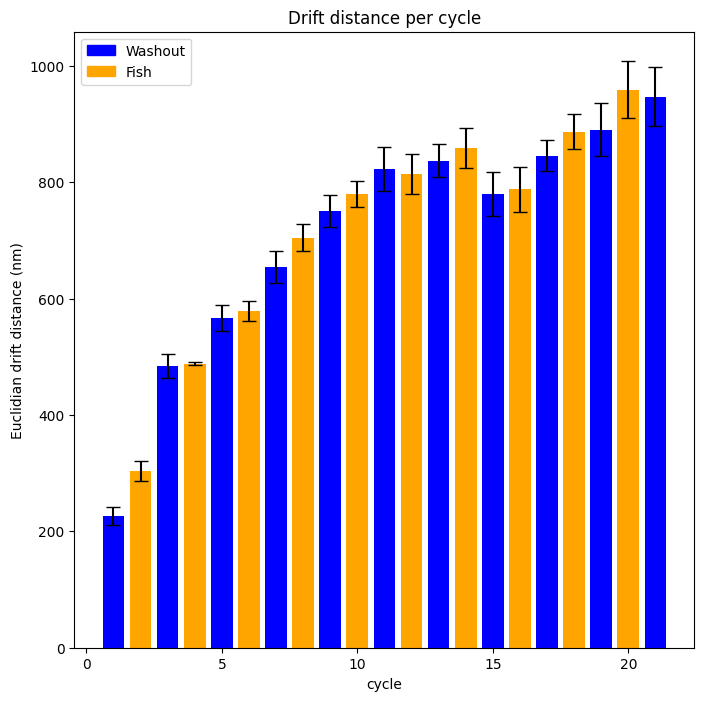

In [35]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()

X = fish_data.index
Y = fish_data.loc[:,('euclidian_drift','mean')]
error_bar = fish_data.loc[:,('euclidian_drift','confidence_interval')]
color = ['blue','orange']
labels = ['fish', 'washout']

legend_symb = [p.Rectangle((0,0),0,1, color= 'blue'), p.Rectangle((0,0),0,1, color= 'orange')]
plt.legend(legend_symb,['Washout','Fish'])

ax.bar(X, Y, color=color, yerr = error_bar, capsize=5)
ax.set_ylabel('Euclidian drift distance (nm)')
ax.set_xlabel('cycle')
ax.set_title('Drift distance per cycle')

xmin,xmax,ymin,ymax = plt.axis()

ax.set_ylim(0,ymax)

plt.show()